# Lecture 8: Normalizing Flows

## 1. Introduction to Normalizing Flows
Normalizing Flows (NFs) are powerful generative models that learn invertible transformations between simple target distributions like Gaussians, and complex data distributions such as images.

The fundamental equation for NFs is given by the change of variables formula:

$$
p_{\mathbf{X}}(\mathbf{x})=p_{\mathbf{Z}}(\mathbf{z})\left|\operatorname{det} \frac{\mathrm{d} f(\mathbf{z})}{\mathrm{d} \mathbf{z}}\right|^{-1}
$$

<!-- where $z \sim p_Z$ is our latent variable and $f$ is our bijective transformation, $\mathbf{x} = f(\mathbf{z})$. To model complex relationships while maintaining invertibility $f$ will be discretized into a sequence of $K$ bijective functions $f_k\,$:$\,\mathbb{R}^D \rightarrow \mathbb{R}^D$ (for $k=1,2,\ldots,K$), intermediate variables $\mathbf{z}_k$ and the sequential mapping $\mathbf{z}_0 = f_K \circ f_{K-1} \circ ... \circ f_1 (\mathbf{x})$. As a result, explicit likelihood estimation can be obtained with -->

where $ \mathbf{z} \sim p_{\mathbf{Z}} $ is a latent variable, and $ f $ is an invertible transformation such that $ \mathbf{x} = f(\mathbf{z}) $. To ensure both expressivity and invertibility, $ f $ is factorized into a sequence of $ K $ bijective functions $ f_k: \mathbb{R}^D \to \mathbb{R}^D $ (for $ k=1,2,\ldots,K $), introducing intermediate variables $ \mathbf{z}_k $ through the mapping:

$$
\mathbf{z}_0 = f_K \circ f_{K-1} \circ \dots \circ f_1 (\mathbf{x}).
$$

This enables explicit likelihood computation via:

$$
\log p_{\mathbf{X}}(\mathbf{x})=\log p_{\mathbf{Z}}\left(\mathbf{z}_0\right)-\sum_{k=1}^K \log \left|\operatorname{det} \frac{\partial f_k(z_{k-1})}{\partial \mathbf{z}_{k-1}}\right|.
$$

The figure below, taken from lecture notes 8A-II, illustrates a Normalizing Flow.
In summary, Normalizing Flows provide the following key advantages:

- **Explicit likelihood calculation** through change-of-variables formula and bijectivity
- **Stable training** due to direct likelihood optimization
- **Bijective mapping** enables both generation and density estimation


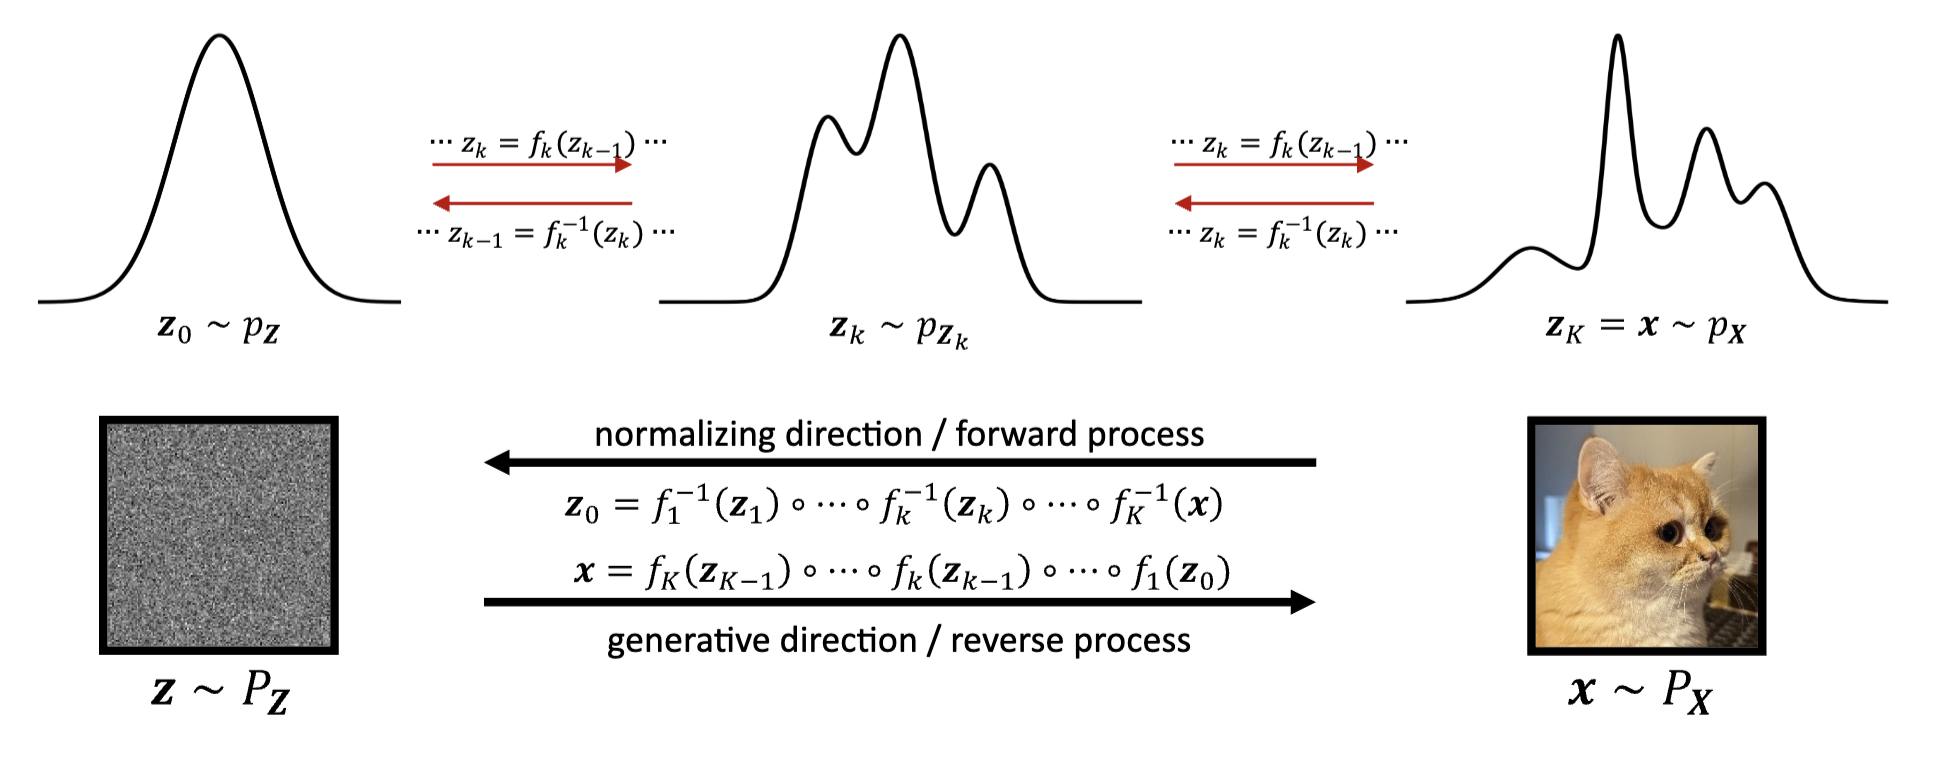

For a more detailed look on Normalizing Flows, we recommend to take a look at the [lecture notes](https://canvas.tue.nl/courses/30012/files/5950016?module_item_id=634049).



## 2. RealNVP Architecture

[RealNVP (Real-valued Non-Volume Preserving) transformations](https://arxiv.org/pdf/1605.08803) is a widely used variant of Normalizing Flows that employs affine coupling layers to enable efficient, invertible transformations. In this notebook, we will implement, train, and sample from RealNVP to gain an intuitive understanding of how Normalizing Flows operate.

We begin by importing the necessary modules.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.utils as utils
import functools
import numpy as np
from tqdm import tqdm
from enum import IntEnum
import matplotlib.pyplot as plt
import os

### Squeezing  

To efficiently handle high-dimensional data, RealNVP utilizes a multi-scale architecture, which is implemented using a squeezing operation. Directly passing a $ D $-dimensional input through all coupling layers would be computationally expensive, leading to excessive parameterization and memory consumption. The squeezing operation mitigates this by reducing spatial resolution while increasing the number of channels, improving both efficiency and expressivity.  

The squeezing operation rearranges spatial information into the channel dimension $c$. It takes an input tensor of shape $ s \times s \times c $ and transforms it into a tensor of size $ \frac{s}{2} \times \frac{s}{2} \times 4c $. This operation effectively compresses spatial information, enabling coupling layers to operate on a more compact representation with a larger receptive field.


In [3]:

def squeeze_2x2(x, reverse=False, alt_order=False):
    """For each spatial position, a sub-volume of shape `1x1x(N^2 * C)`,
    reshape into a sub-volume of shape `NxNxC`, where `N = block_size`.

    Adapted from:
        https://github.com/tensorflow/models/blob/master/research/real_nvp/real_nvp_utils.py

    See Also:
        - TensorFlow nn.depth_to_space: https://www.tensorflow.org/api_docs/python/tf/nn/depth_to_space
        - Figure 3 of RealNVP paper: https://arxiv.org/abs/1605.08803

    Args:
        x (torch.Tensor): Input tensor of shape (B, C, H, W).
        reverse (bool): Whether to do a reverse squeeze (unsqueeze).
        alt_order (bool): Whether to use alternate ordering.
    """
    block_size = 2
    if alt_order:
        n, c, h, w = x.size()

        if reverse:
            if c % 4 != 0:
                raise ValueError('Number of channels must be divisible by 4, got {}.'.format(c))
            c //= 4
        else:
            if h % 2 != 0:
                raise ValueError('Height must be divisible by 2, got {}.'.format(h))
            if w % 2 != 0:
                raise ValueError('Width must be divisible by 4, got {}.'.format(w))
        # Defines permutation of input channels (shape is (4, 1, 2, 2)).
        squeeze_matrix = torch.tensor([[[[1., 0.], [0., 0.]]],
                                       [[[0., 0.], [0., 1.]]],
                                       [[[0., 1.], [0., 0.]]],
                                       [[[0., 0.], [1., 0.]]]],
                                      dtype=x.dtype,
                                      device=x.device)
        perm_weight = torch.zeros((4 * c, c, 2, 2), dtype=x.dtype, device=x.device)
        for c_idx in range(c):
            slice_0 = slice(c_idx * 4, (c_idx + 1) * 4)
            slice_1 = slice(c_idx, c_idx + 1)
            perm_weight[slice_0, slice_1, :, :] = squeeze_matrix
        shuffle_channels = torch.tensor([c_idx * 4 for c_idx in range(c)]
                                        + [c_idx * 4 + 1 for c_idx in range(c)]
                                        + [c_idx * 4 + 2 for c_idx in range(c)]
                                        + [c_idx * 4 + 3 for c_idx in range(c)])
        perm_weight = perm_weight[shuffle_channels, :, :, :]

        if reverse:
            x = F.conv_transpose2d(x, perm_weight, stride=2)
        else:
            x = F.conv2d(x, perm_weight, stride=2)
    else:
        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1)

        if reverse:
            if c % 4 != 0:
                raise ValueError('Number of channels {} is not divisible by 4'.format(c))
            x = x.view(b, h, w, c // 4, 2, 2)
            x = x.permute(0, 1, 4, 2, 5, 3)
            x = x.contiguous().view(b, 2 * h, 2 * w, c // 4)
        else:
            if h % 2 != 0 or w % 2 != 0:
                raise ValueError('Expected even spatial dims HxW, got {}x{}'.format(h, w))
            x = x.view(b, h // 2, 2, w // 2, 2, c)
            x = x.permute(0, 1, 3, 5, 2, 4)
            x = x.contiguous().view(b, h // 2, w // 2, c * 4)

        x = x.permute(0, 3, 1, 2)

    return x

### Masking

Coupling layers partition the input into two parts, which is realized using two masking schemes: checkerboard and channel-wise masking. These partitioning schemes exploit the local spatial correlation structure of images.

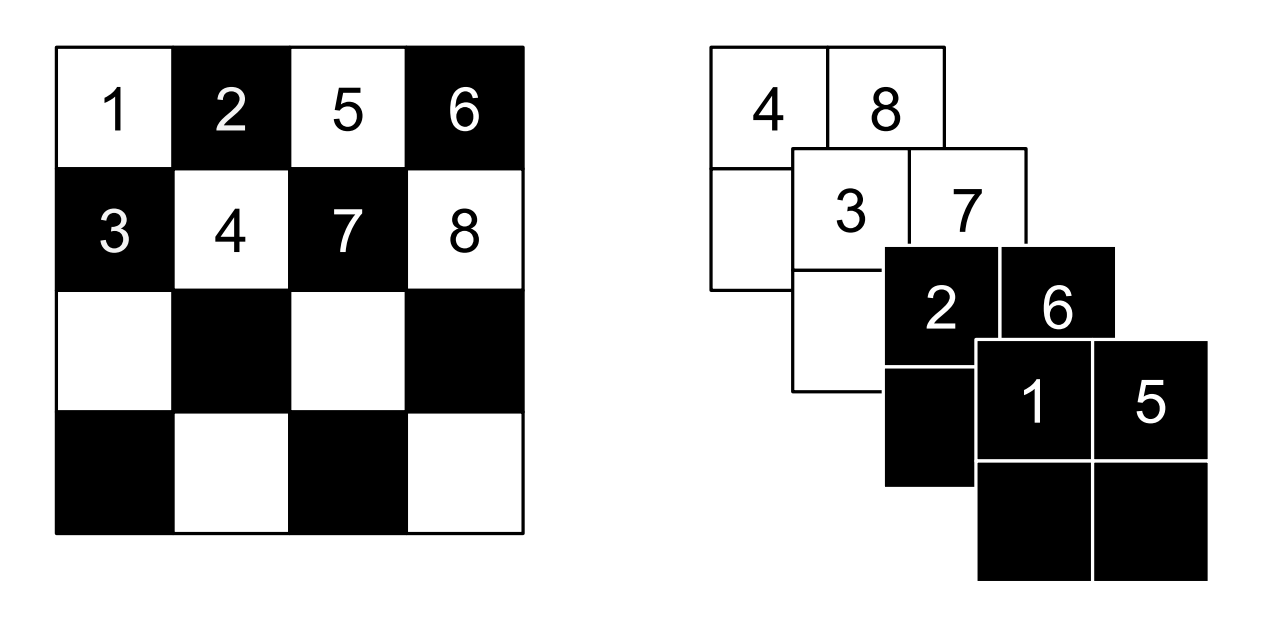

The figure, taken from the [RealNVP paper](https://arxiv.org/pdf/1605.08803), shows the two masking schemes. The checkerboard mask on the left alternates masked and unmasked pixels in a grid-like fashion, ensuring information is gradually propagated across spatial locations. This is particularly useful in image data, where adjacent pixels share strong correlations. 

The channel-wise masking is applied after the squeezing operation, whereas the checkerboard mask is used before squeezing.

In [4]:
class MaskType(IntEnum):
    CHECKERBOARD = 0
    CHANNEL_WISE = 1


def checkerboard_mask(height, width, reverse=False, dtype=torch.float32,
                      device=None, requires_grad=False):
    """Get a checkerboard mask, such that no two entries adjacent entries
    have the same value. In non-reversed mask, top-left entry is 0.

    Args:
        height (int): Number of rows in the mask.
        width (int): Number of columns in the mask.
        reverse (bool): If True, reverse the mask (i.e., make top-left entry 1).
            Useful for alternating masks in RealNVP.
        dtype (torch.dtype): Data type of the tensor.
        device (torch.device): Device on which to construct the tensor.
        requires_grad (bool): Whether the tensor requires gradient.


    Returns:
        mask (torch.tensor): Checkerboard mask of shape (1, 1, height, width).
    """
    checkerboard = [[((i % 2) + j) % 2 for j in range(width)] for i in range(height)]
    mask = torch.tensor(checkerboard, dtype=dtype, device=device, requires_grad=requires_grad)

    if reverse:
        mask = 1 - mask

    # Reshape to (1, 1, height, width) for broadcasting with tensors of shape (B, C, H, W)
    mask = mask.view(1, 1, height, width)

    return mask


### Coupling Flow

The *Coupling Flow* is one of the most popular category of flow transformations, which works well with the use of deep neural networks. Flow transformations should be sufficiently expressive while being invertible and differentiable.

Coupling layers split the input $\mathbf{x}$ arbitrarily into two parts $\mathbf{x}_A$ and $\mathbf{x}_B$, and defines the transformation $f$ as

$$ 
\mathbf{x}_A' = h(\mathbf{x}_A; \Theta(\mathbf{x}_B))
\\
\mathbf{x}_B' = \mathbf{x}_B
$$

Here,  $h(\cdot)$ is our coupling function. Various coupling functions exist; however, the most commonly used approach is the affine coupling function. 



### Affine Coupling  

Affine coupling layers provide an efficient way to construct invertible transformations while maintaining computational tractability. Given a $ D$-dimensional input $ \mathbf{x}$, the transformation function $ f$ for an affine coupling layer is defined as:

$$
\mathbf{x}_{1:d}' = \mathbf{x}_{1:d}
$$
$$
\mathbf{x}_{d+1:D}' = \mathbf{x}_{d+1:D} \cdot e^{s(\mathbf{x}_{1:d})} + t(\mathbf{x}_{1:d}) ,
$$

where $ s(\cdot)$ and $ t(\cdot)$ are scale and translation functions, and $ d < D$.

Since Normalizing Flows rely on explicit likelihood estimation via the change-of-variables formula, we require the Jacobian determinant of the transformation. The Jacobian matrix of the affine coupling function is:

$$
\frac{\partial x'}{\partial x^T}=\left[\begin{array}{cc}
\mathbb{I}_d & 0 \\
\frac{\partial x'_{d+1: D}}{\partial x_{1: d}^T} & \operatorname{diag}\left(\exp \left[s\left(x_{1: d}\right)\right]\right)
\end{array}\right]
$$

A key advantage of affine coupling layers is that the Jacobian determinant depends only on the scale function $ s(\mathbf{x}_{1:d})$, making it simple to compute as the product of diagonal elements. Moreover, the inverse transformation is straightforward, as the first $ d$ dimensions remain unchanged while the remaining $ D - d$ dimensions undergo an element-wise transformation.

The scale and translation functions $s$ and $ t$ can be parameterized by deep neural networks, allowing them to be arbitrarily complex. 


In [5]:
class CouplingLayer(nn.Module):
    """Coupling layer in RealNVP.

    Args:
        in_channels (int): Number of channels in the input.
        mid_channels (int): Number of channels in the `s` and `t` network.
        num_blocks (int): Number of residual blocks in the `s` and `t` network.
        mask_type (MaskType): One of `MaskType.CHECKERBOARD` or `MaskType.CHANNEL_WISE`.
        reverse_mask (bool): Whether to reverse the mask. Useful for alternating masks.
    """
    def __init__(self, in_channels, mid_channels, num_blocks, mask_type, reverse_mask):
        super(CouplingLayer, self).__init__()

        # Save mask info
        self.mask_type = mask_type
        self.reverse_mask = reverse_mask

        # Build scale and translate network
        if self.mask_type == MaskType.CHANNEL_WISE:
            in_channels //= 2
        self.st_net = ResNet(in_channels, mid_channels, 2 * in_channels,
                             num_blocks=num_blocks, kernel_size=3, padding=1,
                             double_after_norm=(self.mask_type == MaskType.CHECKERBOARD))

        # Learnable scale for s
        self.rescale = nn.utils.parametrizations.weight_norm(Rescale(in_channels))

    def forward(self, x, sldj=None, reverse=True):
        if self.mask_type == MaskType.CHECKERBOARD:
            # Checkerboard mask
            b = checkerboard_mask(x.size(2), x.size(3), self.reverse_mask, device=x.device)
            x_b = x * b
            st = self.st_net(x_b)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))
            s = s * (1 - b)
            t = t * (1 - b)

            # Scale and translate
            if reverse:
                inv_exp_s = s.mul(-1).exp()
                if torch.isnan(inv_exp_s).any():
                    raise RuntimeError('Scale factor has NaN entries')
                x = x * inv_exp_s - t
            else:
                exp_s = s.exp()
                if torch.isnan(exp_s).any():
                    raise RuntimeError('Scale factor has NaN entries')
                x = (x + t) * exp_s

                # Add log-determinant of the Jacobian
                sldj += s.reshape(s.size(0), -1).sum(-1)
        else:
            # Channel-wise mask
            if self.reverse_mask:
                x_id, x_change = x.chunk(2, dim=1)
            else:
                x_change, x_id = x.chunk(2, dim=1)

            st = self.st_net(x_id)
            s, t = st.chunk(2, dim=1)
            s = self.rescale(torch.tanh(s))

            # Scale and translate
            if reverse:
                inv_exp_s = s.mul(-1).exp()
                if torch.isnan(inv_exp_s).any():
                    raise RuntimeError('Scale factor has NaN entries')
                x_change = x_change * inv_exp_s - t
            else:
                exp_s = s.exp()
                if torch.isnan(exp_s).any():
                    raise RuntimeError('Scale factor has NaN entries')
                x_change = (x_change + t) * exp_s

                # Add log-determinant of the Jacobian
                sldj += s.reshape(s.size(0), -1).sum(-1)

            if self.reverse_mask:
                x = torch.cat((x_id, x_change), dim=1)
            else:
                x = torch.cat((x_change, x_id), dim=1)

        return x, sldj
    
class Rescale(nn.Module):
    """Per-channel rescaling. Need a proper `nn.Module` so we can wrap it
    with `torch.nn.utils.parametrizations.weight_norm`.

    Args:
        num_channels (int): Number of channels in the input.
    """
    def __init__(self, num_channels):
        super(Rescale, self).__init__()
        self.weight = nn.Parameter(torch.ones(num_channels, 1, 1))

    def forward(self, x):
        x = self.weight * x
        return x

### Final Architecture  

The final multi-scale architecture integrates masking, coupling, and squeezing operations to create an efficient, hierarchical transformation. At each scale, the following steps are applied:  

   - _Three affine coupling layers_ with alternating checkerboard masks.  
   - A _squeeze operation_ is performed to reshape spatial dimensions and increase the number of channels.  
   - _Three additional affine coupling layers_ with alternating *channel-wise masks* refine the representation.  

<!-- $$
\begin{aligned}
h^{(0)} & =x \\
\left(z^{(i+1)}, h^{(i+1)}\right) & =f^{(i+1)}\left(h^{(i)}\right) \\
z^{(L)} & =f^{(L)}\left(h^{(L-1)}\right) \\
z & =\left(z^{(1)}, \ldots, z^{(L)}\right)
\end{aligned}
$$ -->

At each level $ i $, the input $ h^{(i)} $ is split into two parts: one part $ z^{(i+1)} $ is transformed and stored as part of the final latent variable $ z $, while the other part $ h^{(i+1)} $ is further processed by deeper coupling layers. This hierarchical decomposition allows RealNVP to efficiently capture both fine-grained and coarse-level structures in high-dimensional data.

As said earlier, the scale and translation functions $s$ and $t$ in our affine coupling layers can be any sufficient complex architecture. RealNVP uses [ResNet](https://arxiv.org/pdf/1512.03385) blocks, batch normalization, and weight normalization in $s$ and $t$ to improve propagation during training.

In [6]:


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        return functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        return functools.partial(nn.InstanceNorm2d, affine=False)
    else:
        raise NotImplementedError('Invalid normalization type: {}'.format(norm_type))


def get_param_groups(net, weight_decay, norm_suffix='weight_g', verbose=False):
    """Get two parameter groups from `net`: One named "normalized" which will
    override the optimizer with `weight_decay`, and one named "unnormalized"
    which will inherit all hyperparameters from the optimizer.

    Args:
        net (torch.nn.Module): Network to get parameters from
        weight_decay (float): Weight decay to apply to normalized weights.
        norm_suffix (str): Suffix to select weights that should be normalized.
            For WeightNorm, using 'weight_g' normalizes the scale variables.
        verbose (bool): Print out number of normalized and unnormalized parameters.
    """
    norm_params = []
    unnorm_params = []
    for n, p in net.named_parameters():
        if n.endswith(norm_suffix):
            norm_params.append(p)
        else:
            unnorm_params.append(p)

    param_groups = [{'name': 'normalized', 'params': norm_params, 'weight_decay': weight_decay},
                    {'name': 'unnormalized', 'params': unnorm_params}]

    if verbose:
        print('{} normalized parameters'.format(len(norm_params)))
        print('{} unnormalized parameters'.format(len(unnorm_params)))

    return param_groups


class WNConv2d(nn.Module):
    """Weight-normalized 2d convolution.

    Args:
        in_channels (int): Number of channels in the input.
        out_channels (int): Number of channels in the output.
        kernel_size (int): Side length of each convolutional kernel.
        padding (int): Padding to add on edges of input.
        bias (bool): Use bias in the convolution operation.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super(WNConv2d, self).__init__()
        self.conv = nn.utils.parametrizations.weight_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias))

    def forward(self, x):
        x = self.conv(x)

        return x


class BatchNormStats2d(nn.Module):
    """Compute BatchNorm2d normalization statistics: `mean` and `var`.
    Useful for keeping track of sum of log-determinant of Jacobians in flow models.
    Args:
        num_features (int): Number of features in the input (i.e., `C` in `(N, C, H, W)`).
        eps (float): Added to the denominator for numerical stability.
        decay (float): The value used for the running_mean and running_var computation.
            Different from conventional momentum, see `nn.BatchNorm2d` for more.
    """
    def __init__(self, num_features, eps=1e-5, decay=0.1):
        super(BatchNormStats2d, self).__init__()
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.decay = decay

    def forward(self, x, training):
        # Get mean and variance per channel
        if training:
            channels = x.transpose(0, 1).contiguous().view(x.size(1), -1)
            used_mean, used_var = channels.mean(-1), channels.var(-1)
            curr_mean, curr_var = used_mean, used_var

            # Update variables
            self.running_mean = self.running_mean - self.decay * (self.running_mean - curr_mean)
            self.running_var = self.running_var - self.decay * (self.running_var - curr_var)
        else:
            used_mean = self.running_mean
            used_var = self.running_var

        used_var += self.eps

        # Reshape to (N, C, H, W)
        used_mean = used_mean.view(1, x.size(1), 1, 1).expand_as(x)
        used_var = used_var.view(1, x.size(1), 1, 1).expand_as(x)

        return used_mean, used_var
    

def clip_grad_norm(optimizer, max_norm, norm_type=2):
    """Clip the norm of the gradients for all parameters under `optimizer`.

    Args:
        optimizer (torch.optim.Optimizer):
        max_norm (float): The maximum allowable norm of gradients.
        norm_type (int): The type of norm to use in computing gradient norms.
    """
    for group in optimizer.param_groups:
        utils.clip_grad_norm_(group['params'], max_norm, norm_type)

class ResidualBlock(nn.Module):
    """ResNet basic block with weight norm."""
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.in_norm = nn.BatchNorm2d(in_channels)
        self.in_conv = WNConv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

        self.out_norm = nn.BatchNorm2d(out_channels)
        self.out_conv = WNConv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        skip = x

        x = self.in_norm(x)
        x = F.relu(x)
        x = self.in_conv(x)

        x = self.out_norm(x)
        x = F.relu(x)
        x = self.out_conv(x)

        x = x + skip

        return x

class ResNet(nn.Module):
    """ResNet for scale and translate factors in Real NVP.

    Args:
        in_channels (int): Number of channels in the input.
        mid_channels (int): Number of channels in the intermediate layers.
        out_channels (int): Number of channels in the output.
        num_blocks (int): Number of residual blocks in the network.
        kernel_size (int): Side length of each filter in convolutional layers.
        padding (int): Padding for convolutional layers.
        double_after_norm (bool): Double input after input BatchNorm.
    """
    def __init__(self, in_channels, mid_channels, out_channels,
                 num_blocks, kernel_size, padding, double_after_norm):
        super(ResNet, self).__init__()
        self.in_norm = nn.BatchNorm2d(in_channels)
        self.double_after_norm = double_after_norm
        self.in_conv = WNConv2d(2 * in_channels, mid_channels, kernel_size, padding, bias=True)
        self.in_skip = WNConv2d(mid_channels, mid_channels, kernel_size=1, padding=0, bias=True)

        self.blocks = nn.ModuleList([ResidualBlock(mid_channels, mid_channels)
                                     for _ in range(num_blocks)])
        self.skips = nn.ModuleList([WNConv2d(mid_channels, mid_channels, kernel_size=1, padding=0, bias=True)
                                    for _ in range(num_blocks)])

        self.out_norm = nn.BatchNorm2d(mid_channels)
        self.out_conv = WNConv2d(mid_channels, out_channels, kernel_size=1, padding=0, bias=True)

    def forward(self, x):
        x = self.in_norm(x)
        if self.double_after_norm:
            x *= 2.
        x = torch.cat((x, -x), dim=1)
        x = F.relu(x)
        x = self.in_conv(x)
        x_skip = self.in_skip(x)

        for block, skip in zip(self.blocks, self.skips):
            x = block(x)
            x_skip += skip(x)

        x = self.out_norm(x_skip)
        x = F.relu(x)
        x = self.out_conv(x)

        return x

### Optimization 

Normalizing Flows, like other generative models, are trained using Maximum Likelihood Estimation (MLE). This involves minimizing the negative log-likelihood (NLL), which is equivalent to maximizing the likelihood of the data under the model. By directly optimizing likelihood, Normalizing Flows enable stable and efficient training while ensuring an explicit density estimation. See the `RealNVPLoss` class and `train_model()` function below.

A common evaluation metric for generative models, particularly in Normalizing Flows, is bits per dimension (bpd). This metric originates from information theory and quantifies the number of bits required to encode a given data point under the learned distribution. A lower bpd indicates that the model assigns higher likelihood to the data, implying a better fit. By computing the bpd on a held-out test set, we can assess the generalization ability of the model and verify that it captures meaningful structure rather than merely memorizing training samples.

The bpd score is computed from the negative log-likelihood by converting the logarithm to base 2, since bits are measured in binary while NLL is typically expressed in natural logarithms:

$$
bpd = NLL \cdot \log_2 (\exp(1)) \cdot \prod^N d_i^{-1},
$$

where $d_i$ are the dimensions of a $N$-dimensional input. For example, in the case of an image, $\prod^N d_i$ corresponds to the product of height, width, and number of channels as seen in `bits_per_dim(x, nll)`. 

### Dequantization

Normalizing Flows are formulated under the assumption of continuous probability density functions, yet real-world data, such as images, are inherently discrete. Natural images are typically stored using 8-bit densitites, while they are treated in theory as an instance of a continuous random variable.
A direct consequence of this discrepancy is that the differential entropy of a discrete distribution is theoretically negative infinity, which can lead to arbitrarily high likelihood values--even on unseen test samples. To mitigate this issue, a common technique known as _dequantization_ is applied. This involves adding real-valued noise to discrete pixel values. If an appropriate amount of uniform noise is added to discrete data, the log-likelihood of the resulting continuous model closely approximates the log-likelihood of a discrete model applied to the original data. This ensures that optimizing the log-likelihood in the continuous domain also indirectly optimizes the likelihood of the discrete model.

By introducing uniform noise for dequantization, we effectively smooth the discrete data distribution, allowing the continuous density model to provide meaningful likelihood estimates. In this way, the learning objective remains aligned with the original discrete data distribution while maintaining a well-defined probability density function. This is implemented in the `_pre_process()` function.


In [7]:



class _RealNVP(nn.Module):
    """Recursive builder for a `RealNVP` model.

    Each `_RealNVPBuilder` corresponds to a single scale in `RealNVP`,
    and the constructor is recursively called to build a full `RealNVP` model.

    Args:
        scale_idx (int): Index of current scale.
        num_scales (int): Number of scales in the RealNVP model.
        in_channels (int): Number of channels in the input.
        mid_channels (int): Number of channels in the intermediate layers.
        num_blocks (int): Number of residual blocks in the s and t network of
            `Coupling` layers.
    """
    def __init__(self, scale_idx, num_scales, in_channels, mid_channels, num_blocks, img_size=32):
        super(_RealNVP, self).__init__()

        self.is_last_block = scale_idx == num_scales - 1

        self.in_couplings = nn.ModuleList([
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=False),
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=True),
            CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=False)
        ])

        if self.is_last_block:
            self.in_couplings.append(
                CouplingLayer(in_channels, mid_channels, num_blocks, MaskType.CHECKERBOARD, reverse_mask=True))
        else:
            self.out_couplings = nn.ModuleList([
                CouplingLayer(4 * in_channels, 2 * mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=False),
                CouplingLayer(4 * in_channels, 2 * mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=True),
                CouplingLayer(4 * in_channels, 2 * mid_channels, num_blocks, MaskType.CHANNEL_WISE, reverse_mask=False)
            ])
            self.next_block = _RealNVP(scale_idx + 1, num_scales, 2 * in_channels, 2 * mid_channels, num_blocks)

    def forward(self, x, sldj, reverse=False):
        if reverse:
            if not self.is_last_block:
                # Re-squeeze -> split -> next block
                x = squeeze_2x2(x, reverse=False, alt_order=True)
                x, x_split = x.chunk(2, dim=1)
                x, sldj = self.next_block(x, sldj, reverse)
                x = torch.cat((x, x_split), dim=1)
                x = squeeze_2x2(x, reverse=True, alt_order=True)

                # Squeeze -> 3x coupling (channel-wise)
                x = squeeze_2x2(x, reverse=False)
                for coupling in reversed(self.out_couplings):
                    x, sldj = coupling(x, sldj, reverse)
                x = squeeze_2x2(x, reverse=True)

            for coupling in reversed(self.in_couplings):
                x, sldj = coupling(x, sldj, reverse)
        else:
            for coupling in self.in_couplings:
                x, sldj = coupling(x, sldj, reverse)

            if not self.is_last_block:
                # Squeeze -> 3x coupling (channel-wise)
                x = squeeze_2x2(x, reverse=False)
                for coupling in self.out_couplings:
                    x, sldj = coupling(x, sldj, reverse)
                x = squeeze_2x2(x, reverse=True)

                # Re-squeeze -> split -> next block
                x = squeeze_2x2(x, reverse=False, alt_order=True)
                x, x_split = x.chunk(2, dim=1)
                x, sldj = self.next_block(x, sldj, reverse)
                x = torch.cat((x, x_split), dim=1)
                x = squeeze_2x2(x, reverse=True, alt_order=True)

        return x, sldj   



class RealNVP(nn.Module):
    """RealNVP Model

    Based on the paper:
    "Density estimation using Real NVP"
    by Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio
    (https://arxiv.org/abs/1605.08803).

    Args:
        num_scales (int): Number of scales in the RealNVP model.
        in_channels (int): Number of channels in the input.
        mid_channels (int): Number of channels in the intermediate layers.
        num_blocks (int): Number of residual blocks in the s and t network of
        `Coupling` layers.
    """
    def __init__(self, img_size, in_channels, args):
        super(RealNVP, self).__init__()
        # Register data_constraint to pre-process images, not learnable
        self.register_buffer('data_constraint', torch.tensor([0.9], dtype=torch.float32))

        self.flows = _RealNVP(0, args.num_scales, in_channels, args.mid_channels, args.num_blocks)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.flows.to(self.device)
        self.img_size = img_size
        self.channels = in_channels

    def forward(self, x, reverse=False):
        sldj = None
        if not reverse:
            # Expect inputs in [0, 1]
            if x.min() < 0 or x.max() > 1:
                raise ValueError('Expected x in [0, 1], got x with min/max {}/{}'
                                 .format(x.min(), x.max()))

            # De-quantize and convert to logits
            x, sldj = self._pre_process(x)

        x, sldj = self.flows(x, sldj, reverse)

        return x, sldj

    def _pre_process(self, x):
        """Dequantize the input image `x` and convert to logits.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            y (torch.Tensor): Dequantized logits of `x`.

        See Also:
            - Dequantization: https://arxiv.org/abs/1511.01844, Section 3.1
            - Modeling logits: https://arxiv.org/abs/1605.08803, Section 4.1
        """
        y = (x * 255. + torch.rand_like(x)) / 256.
        y = (2 * y - 1) * self.data_constraint.to(self.device)
        y = (y + 1) / 2
        y = y.log() - (1. - y).log()

        # Save log-determinant of Jacobian of initial transform
        ldj = F.softplus(y) + F.softplus(-y) \
            - F.softplus((1. - self.data_constraint.to(self.device)).log() - self.data_constraint.to(self.device).log())
        sldj = ldj.view(ldj.size(0), -1).sum(-1)

        return y, sldj
    

    def train_model(self, dataloader, args, verbose=True):
        """Train the RealNVP model.

        Args:
            dataloader (DataLoader): DataLoader for the training set.
            args (argparse.Namespace): Command-line arguments.
        """
        models_dir = args.models_dir
        create_checkpoint_dir(models_dir)

        loss = RealNVPLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=args.lr)

        # epoch_bar = trange(args.n_epochs, desc='Epochs', leave=True)

        best_loss = np.inf

        for epoch in range(args.n_epochs):
            self.train()
            loss_epoch = 0.
            for x,_ in tqdm(dataloader, desc='Batches', leave=True):
                x = x.to(self.device)

                optimizer.zero_grad()
                z, sldj = self.forward(x, reverse=False)
                nll = loss(z, sldj)

                nll.backward()
                clip_grad_norm(optimizer, args.max_grad_norm)
                optimizer.step()
                loss_epoch += nll.item()*x.size(0)

            loss_epoch /= len(dataloader.dataset)
            # epoch_bar.set_postfix(loss=loss_epoch)
            print(f"train_loss at epoch {epoch}: {loss_epoch}")

            if loss_epoch < best_loss:
                best_loss = loss_epoch
                torch.save(self.state_dict(), os.path.join(models_dir, 'RealNVP.pt'))
            
            if (epoch + 1) % args.sample_and_save_freq == 0 or epoch == 0:
                self.sample(16, train=True, epoch=epoch)
    

    def sample(self, n_samples, train=False, epoch=None):
        """Sample from RealNVP model.

        Args:
            net (torch.nn.DataParallel): The RealNVP model wrapped in DataParallel.
            batch_size (int): Number of samples to generate.
            train (bool): Whether to log samples as training samples.
        """
        self.eval()
        z = torch.randn((n_samples, self.channels, self.img_size, self.img_size), dtype=torch.float32, device=self.device)
        x, _ = self.forward(z, reverse=True)
        x = torch.sigmoid(x)

        x = x.clamp(0, 1).cpu().detach()
        grid = make_grid(x, nrow=int(n_samples ** 0.5), padding=0)
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        if train:
            print(f"training samples saved at epoch {epoch}")
            plt.savefig(f"epoch{epoch}_training_samples_{n_samples}.png")
        else:
            plt.show()
            plt.savefig(f"generated_samples_{n_samples}.png")
    
    def nll_score(self, z, sldj):
        k = 256
        prior_ll = -0.5 * (z ** 2 + np.log(2 * np.pi))
        prior_ll = prior_ll.view(z.size(0), -1).sum(-1) \
            - np.log(k) * np.prod(z.size()[1:])
        ll = prior_ll + sldj
        nll = -ll
        return nll
    

class RealNVPLoss(nn.Module):
    """Get the NLL loss for a RealNVP model.

    Args:
        k (int or float): Number of discrete values in each input dimension.
            E.g., `k` is 256 for natural images.

    See Also:
        Equation (3) in the RealNVP paper: https://arxiv.org/abs/1605.08803
    """
    def __init__(self, k=256):
        super(RealNVPLoss, self).__init__()
        self.k = k

    def forward(self, z, sldj):
        prior_ll = -0.5 * (z ** 2 + np.log(2 * np.pi))
        prior_ll = prior_ll.view(z.size(0), -1).sum(-1) \
            - np.log(self.k) * np.prod(z.size()[1:])
        ll = prior_ll + sldj
        nll = -ll.mean()

        return nll
    
def create_checkpoint_dir(models_dir):
    """Create a directory to save model checkpoints."""
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    if not os.path.exists(os.path.join(models_dir, 'RealNVP')):
        os.makedirs(os.path.join(models_dir, 'RealNVP'))


def bits_per_dim(x, nll):
    """Get the bits per dimension implied by using model with `loss`
    for compressing `x`, assuming each entry can take on `k` discrete values.

    Args:
        x (torch.Tensor): Input to the model. Just used for dimensions.
        nll (torch.Tensor): Scalar negative log-likelihood loss tensor.

    Returns:
        bpd (torch.Tensor): Bits per dimension implied if compressing `x`.
    """
    dim = np.prod(x.size()[1:])
    bpd = nll / (np.log(2) * dim)

    return bpd

### Training on MNIST images 

Since Normalizing Flows are computationally expensive, we will train on a resized subset of the MNIST dataset. The images are resized to 14x14, and we only select the digits '0' and '2' to train on. 

In [11]:
class FilteredMNIST(datasets.MNIST):
    def __init__(self, *args, labels_to_keep=[0,2], **kwargs):
        super(FilteredMNIST, self).__init__(*args, **kwargs)
        self.labels_to_keep = labels_to_keep
        self.filtered_indices = [i for i, label in enumerate(self.targets) if label in self.labels_to_keep]
        self.data = self.data[self.filtered_indices]
        self.targets = self.targets[self.filtered_indices]

# train_dataset = FilteredMNIST(
#     root='./data', 
#     train=True,
#     download=True, 
#     transform=transforms.ToTensor()
# )

# Uncomment this to use the full MNIST dataset
train_dataset = datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=0
)

It's time to train now, we'll make a config class where we specify our hyperparameters and other arguments for training.

Batches: 100%|██████████| 93/93 [22:02<00:00, 14.22s/it]


train_loss at epoch 0: 2360.4056349838534
training samples saved at epoch 0


Batches: 100%|██████████| 93/93 [21:41<00:00, 14.00s/it]


train_loss at epoch 1: 1494.20818874493


Batches: 100%|██████████| 93/93 [21:38<00:00, 13.96s/it]


train_loss at epoch 2: 1507.7018626341262


Batches:  45%|████▌     | 42/93 [09:58<12:06, 14.25s/it]


KeyboardInterrupt: 

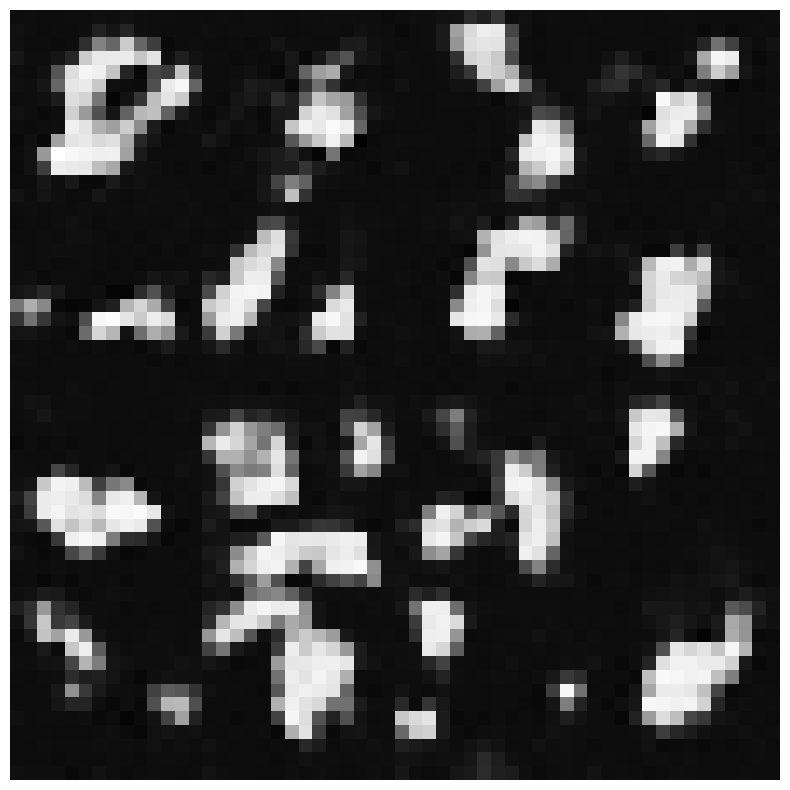

In [9]:
# Config class to store training hyperparameters, modify as desired
class Config:
    def __init__(self):
        self.batch_size = 128          # Batch size for training
        self.n_epochs = 10             # Number of epochs
        self.lr = 1e-3                 # Learning rate
        self.weight_decay = 1e-5       # Weight decay for optimizer
        self.max_grad_norm = 100.0     # Maximum gradient norm
        self.sample_and_save_freq = 5  # Frequency of saving samples
        self.num_scales = 2            # Number of scales in the RealNVP model
        self.mid_channels = 64         # Number of intermediate channels
        self.num_blocks = 8            # Number of blocks in the model
        self.checkpoint = None         # Path to a checkpoint file (if any)
        self.no_wandb = False          # Disable wandb logging
        self.num_workers = 0           # Number of workers for data loader
        self.models_dir = "./models"   # Directory to save models


args = Config()

image_size = 14  # Set to 14 to reduce computational load
n_channels = 1   # 1 for grayscale images, 3 for RGB

# Initialize the RealNVP model
model = RealNVP(image_size, n_channels, args)

# Start training
model.train_model(train_dataloader, args)

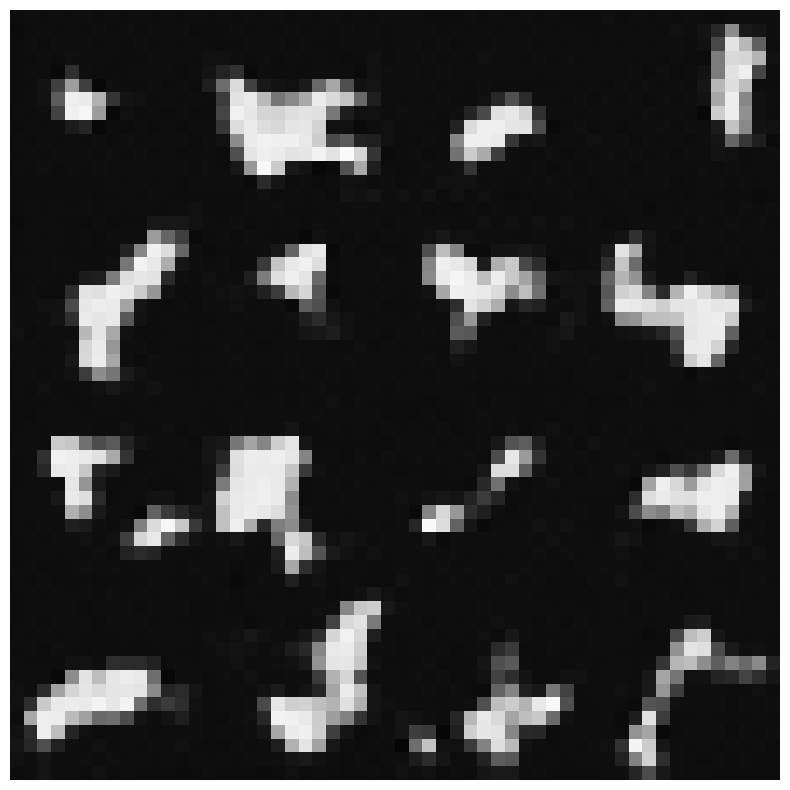

<Figure size 640x480 with 0 Axes>

In [10]:
model.eval()
model.sample(16, train=False)

# Questions

1. Show that maximizing the likelihood is equivalent to minimizing the KL-divergence. 
2. Derive the Jacobian and its determinant of a coupling flow.
3. What is the output dimension of a latent variable $z$, given that the input image has a dimension of 32x32x3?
4. Why are Normalizing Flows computationally expensive?
